In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax
from src import CARPoolEmulator, CARPoolSimulations
import scienceplots
from scipy.stats import binned_statistic
from astropy import units as un
from astropy.constants import m_e
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# Welcome to the profile emulator edition of CARPoolGP

Ok, so from the previous tutorials, you know that we can emulate a quantity as a function of parameter space, so how then do we emulate a profile? Well, we just create N emulators where N is the number of radial bins! Here we put all of the emulators into a list, and each time you want to emulate a radial profile, you call each of them in order. We have a bunch of data extracted from the zoom-in simulations, you can find them in two files. One has xray surface brightness profiles, the other has thermodynamic profiles like density and temperature and metallicity

In [68]:
np.load('Data/xsb_profiles.npz').files

['xsb_profiles', 'radius_bins_kpc', 'parameters', 'N']

In [69]:
np.load('Data/gas_profiles.npz').files

['ngas_cm3_profiles',
 'temperature_keV_profiles',
 'metallicity_Zsun_profile',
 'radius_bins_kpc',
 'parameters',
 'N']

In this guide, we need to read in the data and associated parameter space locations, train the emulator, and then we can generate predictions. 

# Reading in the data

## Helper functions

We normalize the parameters and the data before doing training to keep the values of numbers relatively constrained. This is standard procedure, so here I am normalizng by the mean and the standard deviation, $(x - \bar{x}) / \sigma_x$

In [2]:
def normalize_Y(val):
    return (val - np.mean(val)) / np.std(val)
def unnormalize_Y(val, std, mean):
    return val * std + mean
def normalize_X(val, param=None):
    if param is None:
        return (val - fids) / np.abs(lbs-ubs)
    else:
        return (val - fids[param]) / np.abs(lbs[param] - ubs[param])
def unnormalize_X(val, param=None):
    if param is None:
        return val* np.abs(lbs-ubs) + fids
    else:
        return val * np.abs(lbs[param] - ubs[param]) + fids[param]

CARPoolGP requires two types of simulations, base and surrogate. The base are those that exist freely throughout parameter space, the surrogates are matched to a base simulation but exist at relatively confined regions in parameter space. When building the emulator you want to match these up, so here is some code to do it. This is a little bit hacky, but gets the job done. I will explain the numbers so its less "magic"... We ran 4 sets of simulations as follows:

* Stage1: 128 base, 128 matching surrogates -> so zoom_0 is the base and zoom_128 is its surrogate, zoom_1 is matched with zoom_129, etc. 
* Stage2: 128 base, 128 surrogate -> zoom_256 is base matched with surrogate zoom_384 , etc
* Stage3: 64 base, 64 surrogate -> zoom_512 base matched with surrogate zoom_576 etc
* Stage4, 64 base, 64 surrogate -> zoom_640 base matched with surrogate zoom_704, etc. 

There is a column in ```Data/GZ28_params.csv```, titled Surrogate, which if NAN is a base simulation, and if it has a value, it indicates that it is a surrogate, matched to the base that has the value. So you can also use this to organize the data, but in general, it needs to be seperated base and surrogate

In [3]:
def BS_organizer(N, thetas):
    theta_S = []
    theta_B = []
    for i, theta in zip(N, thetas):
        if i <512:
            if (i//128)%2 ==0:
                theta_B.append(theta)
            elif (i//128)%2 ==1:
                theta_S.append(theta)
            else:
                raise Exception("Somethings totally wrong")
        if i>=512:
            if (i//64)%2 ==0:
                theta_B.append(theta)
            elif (i//64)%2 ==1:
                theta_S.append(theta)
            else:
                raise Exception("Somethings totally wrong")
    return np.array(theta_B), np.array(theta_S)

def BS_matcher(N_B, N_S, base, surrogate):
    bases, surrogates = [], []
    for i, b in enumerate(N_B):
        if b < 512:
            if b+128 in N_S:
                bases.append(i)
                j = np.where(b+128 == N_S)[0][0]
                surrogates.append(j)
        if b >=512:
            if b+64 in N_S:
                bases.append(i)
                j = np.where(b+64 == N_S)[0][0]
                surrogates.append(j)
    surrogate = np.concatenate((surrogate[np.array(surrogates)], base[np.delete(np.arange(len(base)), bases)], surrogate[np.delete(np.arange(len(surrogate)), surrogates)]))
    base = base[np.array(bases)]
    return base, surrogate

## Data Functions

Read in the parameters, some of these should be in logspace (following GZ28_param_minmax.csv which is the same as SB28_param_minmax.csv). If there is a logflag, log it. 

In [4]:
import pandas as pd
param_df = pd.read_csv('Data/GZ28_params.csv', index_col=0)
param_info = pd.read_csv('Data/GZ28_param_minmax.csv', index_col=0)
theta_raw = np.asarray(param_df.iloc[:, :29])
theta = theta_raw.copy()
for i, t in enumerate(theta_raw[:, :-1].T):
    if bool(param_info['LogFlag'][i]):
        theta[:, i] = np.log10(theta_raw[:, i])

We want to store the bounds of each parameter and the fiducial value, which again can be taken from the GZ28_param_minmax.csv file. 

In [5]:
lbs = []
ubs = []
fids = []
for i in param_info.T:
    if param_info.loc[i, 'LogFlag'] ==1:
        lbs.append(np.log10(param_info.loc[i, "MinVal"]))
        ubs.append(np.log10(param_info.loc[i, "MaxVal"]))
        fids.append(np.log10(param_info.loc[i, "FiducialVal"]))

    else:
        lbs.append(param_info.loc[i, "MinVal"])
        ubs.append(param_info.loc[i, "MaxVal"])
        fids.append(param_info.loc[i, "FiducialVal"])

lbs.append(13.0)
ubs.append(14.5)
lbs = np.array(lbs)
ubs = np.array(ubs)
fids.append(13.75)
fids = np.array(fids)


All of the functions in the next cell are pretty much the same, but are for extracting different quantities I put a docstring in the first function, but it would be the same in each pretty much. Again, there is likely a less hacky way to do this, but this works fine and makes sense to me! 

In [8]:
def get_xrb(theta, ii):
    """_summary_

    Args:
        theta (array): parameter space locations should be (768, 29) shape
        ii (integer): the radius bin that we are emulating. 

    Returns:
        usable_theta_normalized: normalized parameter space coordinates where quantity is not nan or 0
        Y                      : Normalized quantity that we are emulating
        zoom_num               : Array of zoom numbers that are being used with quantity not nan or 0
        np.std(xraySB)         : the standard deviation of the data (that is not 0 or nan) to unnormalize later
        np.mean(xraySB)        : the mean of the data (that is not 0 or nan) to unnormalize later
    """
    # Organize the data a bit
    data = np.load('Data/xsb_profiles.npz')
    xraySB = data['xsb_profiles'][:, ii]
    
    # Some values might be 0 or nan, but we dont want those in our training
    usable_indices = np.where(xraySB[:]>0) 
    xraySB=np.log10(xraySB[usable_indices])
    bins = np.log10(data['radius_bins_kpc'])

    # Normalize the data
    Y      = normalize_Y(xraySB)
    b = bins[1:] - 1/2 * np.median(np.diff(bins))
    Mass     = data['parameters'][usable_indices, -1]
    zoom_num = data['N'][usable_indices].astype(int)

    
    usable_theta        = theta[zoom_num]
    usable_theta[:, -1] = Mass
    usable_theta_normalized = normalize_X(usable_theta) #Normalizes to between -1 and 1
    
    return usable_theta_normalized, Y, zoom_num, np.std(xraySB), np.mean(xraySB)

def get_ngas(theta, ii):
    # Organize the data a bit
    data = np.load('Data/gas_profiles.npz')
    density = data['ngas_cm3_profiles'][:, ii]
    
    usable_indices = np.where(density[:]>0) 
    density=np.log10(density[usable_indices])
    bins = np.log10(data['radius_bins_kpc'])


    Y      = normalize_Y(density)
    b = bins[1:] - 1/2 * np.median(np.diff(bins))
    Mass     = data['parameters'][usable_indices, -1]
    zoom_num = data['N'][usable_indices].astype(int)

    usable_theta        = theta[zoom_num]
    usable_theta[:, -1] = Mass
    usable_theta_normalized = normalize_X(usable_theta) #Normalizes to between -1 and 1
    return usable_theta_normalized, Y, zoom_num, np.std(density), np.mean(density)

def get_temp(theta, ii):
    # Organize the data a bit
    data = np.load('Data/gas_profiles.npz')
    temp = data['temperature_keV_profiles'][:, ii]
    
    usable_indices = np.where(temp[:]>0) 
    temp=np.log10(temp[usable_indices])
    bins = np.log10(data['radius_bins_kpc'])


    Y      = normalize_Y(temp)
    b = bins[1:] - 1/2 * np.median(np.diff(bins))
    Mass     = data['parameters'][usable_indices, -1]
    zoom_num = data['N'][usable_indices].astype(int)

    usable_theta        = theta[zoom_num]
    usable_theta[:, -1] = Mass
    usable_theta_normalized = normalize_X(usable_theta) #Normalizes to between -1 and 1
    return usable_theta_normalized, Y, zoom_num, np.std(temp), np.mean(temp)

def get_Zsun(theta, ii):
    # Organize the data a bit
    data = np.load('Data/gas_profiles.npz')
    metal = data['metallicity_Zsun_profile'][:, ii]
    
    usable_indices = np.where(metal[:]>0) 
    metal=np.log10(metal[usable_indices])
    bins = np.log10(data['radius_bins_kpc'])


    Y      = normalize_Y(metal)
    b = bins[1:] - 1/2 * np.median(np.diff(bins))
    Mass     = data['parameters'][usable_indices, -1]
    zoom_num = data['N'][usable_indices].astype(int)

    usable_theta        = theta[zoom_num]
    usable_theta[:, -1] = Mass
    usable_theta_normalized = normalize_X(usable_theta) #Normalizes to between -1 and 1
    return usable_theta_normalized, Y, zoom_num, np.std(metal), np.mean(metal)


In [ ]:
def organize_data(X, Y, N):
    """organize the data into simulation and surrogate objects

    Args:
        X (array): Parameter space locations of each quantity
        Y (array): value of the quantity at each parameter space location
        N (array): zoom number to be used in organizing

    Returns:
        sims: CARPoolGP simulation object
        surrs: CARPoolGP surrogate object
    """
    
    # Organize the data
    theta_B, theta_S  = BS_organizer(N, X) 
    Q_B, Q_S          = BS_organizer(N, Y) 
    N_B, N_S          = BS_organizer(N,N)
    Q_B, Q_S          = BS_matcher(N_B, N_S, Q_B, Q_S)
    theta_B, theta_S  = BS_matcher(N_B, N_S, theta_B, theta_S)
    
    # Initialize the simulation/surrogate objects
    sims = CARPoolSimulations.Simulation()
    surrs = CARPoolSimulations.Simulation()

    # Set the parameters and quantities for these simulations
    sims.parameters  = theta_B  ;  sims.quantities  = Q_B
    surrs.parameters = theta_S  ;  surrs.quantities = Q_S
    
    return sims, surrs

# Emulator training

In [10]:
def build_emu(theta, ii, params,get_data, lr=1e-1, iters=10000):
    """build emulator for a given radial bin

    Args:
        theta (array): parameter space locations
        ii (int): radial bin that we are creating
        params (CARPoolGP hyperparams): hyperparameters to use for training
        get_data (function): function for extracting the data
        lr (float, optional): learning rate of the optimizer. Defaults to 1e-1.
        iters (int, optional): Number of iterations in the optimization. Defaults to 10000.

    Returns:
        emu: class that holds the optmized emulator
        std: standard deviation of the data for unnormalizing
        mean: mean of the data for unnormalizing
    """
    # Get the data
    X, Y, N, std, mean = get_data(theta, ii)
    
    # Create simulation objects and surrogate objects
    sims, surrs = organize_data(X, Y, N)

    # build the emulator
    emu = CARPoolEmulator.Emulator(sims, surrs)
    
    #Build an emulator object (this generates the kernels which you can find in the CARPoolKernels file) and trains!
    _ = emu.train(params,learning_rate=lr, max_iterations=iters)

    return emu, std, mean

In [ ]:
bins = np.load('Data/gas_profiles.npz')['radius_bins_kpc'] # Our radial bins, 

In [13]:
names = ['z']# This is the name that we will use in a dictionary if training more profiles u can use more names['xray', 'n', 'temp', 'z']
funcs =[get_Zsun]# the functions we are using, you can use any of these [get_xrb, get_ngas, get_temp, get_Zsun]

In [14]:
super_dict = {}
for name, func in zip(names, funcs):
    temp_dict = {}
    emus = []
    means = []
    stds = []

    # For each radial bin we want to train an emulator, and store it. 
    for i in range(len(bins)):
        # These are the CARPoolGP hyperparameters
        params ={"log_scaleV":np.ones(29), "log_scaleM":np.ones(29), "log_ampV":-0.1, "log_jitterV":-0.0, "log_mean":0.0}
        
        #Train the emulator
        emu, std, mean = build_emu(theta, i, params,func, iters=100)
        
        # Store the emulator into a list
        emus.append(emu)
        means.append(mean)
        stds.append(std)
        print('Finished bin ', i)
    temp_dict['emus'] = emus
    temp_dict['means'] = means
    temp_dict['stds'] = stds
    super_dict[name] = temp_dict

Finished bin  0
Finished bin  1
Finished bin  2
Finished bin  3
Finished bin  4
Finished bin  5
Finished bin  6
Finished bin  7
Finished bin  8
Finished bin  9
Finished bin  10
Finished bin  11
Finished bin  12
Finished bin  13
Finished bin  14
Finished bin  15
Finished bin  16
Finished bin  17
Finished bin  18
Finished bin  19
Finished bin  20
Finished bin  21
Finished bin  22
Finished bin  23
Finished bin  24
Finished bin  25
Finished bin  26
Finished bin  27
Finished bin  28


Ok, so now we have trained, 29 emulators, one for each bin! We have stored this into a dict called super_dict. The only key to this dict is 'z', but if you are training multiple profiles, you can have multiple keys (e.g., 'z', 'n', 'temp', 'xray')

The dictionary is actually a dictionary inside of a dictionary! so we have emus, means and stds as keys for the sub dictionary. 

In [34]:
super_dict.keys(), super_dict['z'].keys()

(dict_keys(['z']), dict_keys(['emus', 'means', 'stds']))

# Emulator predictions

Now we can emulate our profile. 

In [38]:
def predict(P, emus, means, stds, Mass=14):
    """predict a profile at high and low bounds of a parameter while all other parameters are at fiducial.
    Args:
        P (int): The parameter number that you want to modulate
        emus (object): the emulator for each radial bin
        means (array): the means of the quantity for each pradial bin
        stds (array): the stds of the quantity for each radial bin

    Returns:
        ms: the emulated prediction
        std: the emulated standard deviation
    """
    
    # normalize the theta positions at the upper and lower bounds
    l = normalize_X(lbs[P], P)
    u = normalize_X(ubs[P], P)

    # Generate a parameter space location, which is at the fiducial location in parameter space
    test_theta = np.zeros((3, 29))
    test_theta[:, 14] = normalize_X(fids[14], 14) # WindSpecMomentum is actually fiducial at 0
    test_theta[:, P] = np.array([l, 0, u]) # We now have 3 parameter space location we are testing, when P is at lb, fid and ub
    
    # Change the mass to whatever you want between 13-14.5 (in log solar / h)
    test_theta[:, -1] = normalize_X(Mass, 28)
    

    ms, vs = [], []
    # Now for each bin, emulate the value, and unnormalize
    for emu, mean, std in zip(emus, means, stds):
        m, v = emu.predict(test_theta)
        m  = unnormalize_Y(m, std, mean)
        v= v* std**2 
        ms.append(m)
        vs.append(v)
    std = np.array([np.sqrt(np.diag(np.array(vs)[i])) for i in range(len(ms))])
    return np.array(ms), np.array(std)

Ok,so now we can emulate a profile for the upper and lower bounds. You can write this function to predict at an arbitrary parameter space location easily as well, which you will likely need. Lets experiment with the IMF slope, which is parameter 11 (you can get this by looking at the param_info dataframe)

In [40]:
param_info.iloc[11]

ParamName                   IMFslope
AbsMaxDiff                       0.5
LogFlag                            0
FiducialVal                     -2.3
MinVal                          -2.8
MaxVal                          -1.8
Description    IMF slope above 1Msun
Name: 11, dtype: object

In [61]:
M, std = predict(11, super_dict['z']['emus'], super_dict['z']['means'], super_dict['z']['stds'])

In [62]:
# find the bin centers
lbins = np.log10(bins)
b = lbins[1:] - 1/2 * np.median(np.diff(lbins))
b = 10**b

Text(0, 0.5, '$log(Z/Z_\\odot)$')

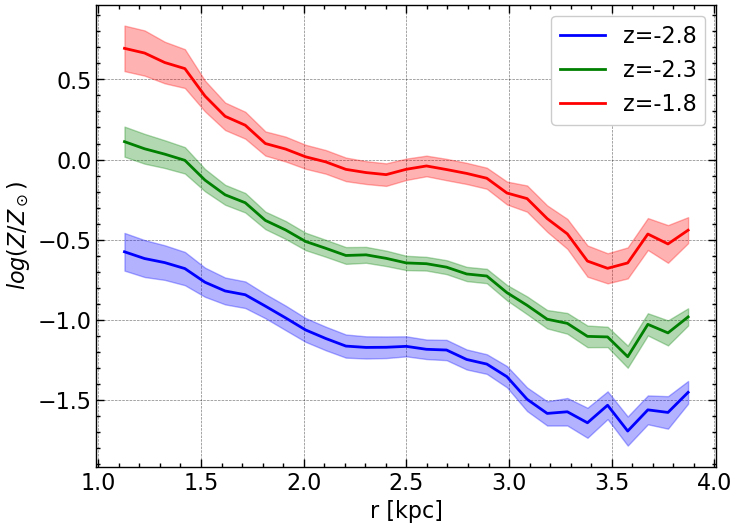

In [63]:
plt.plot(b[:29], M[:, 0], c='b', label="z=-2.8")
plt.fill_between(b[:29], M[:, 0] - std[:, 0], M[:, 0] + std[:, 0], color='b', alpha=0.3)
plt.plot(b[:29], M[:, 1], c='g', label="z=-2.3")
plt.fill_between(b[:29], M[:, 1] - std[:, 1], M[:, 1] + std[:, 1], color='g', alpha=0.3)
plt.plot(b[:29], M[:, 2], c='r', label="z=-1.8")
plt.fill_between(b[:29], M[:, 2] - std[:, 2], M[:, 2] + std[:, 2], color='r', alpha=0.3)
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel(r'$log(Z/Z_\odot)$')

In [43]:
def make_rainbow(emus, means, stds):
    from tqdm.notebook import tqdm as tq
    from matplotlib.colors import Normalize
    from matplotlib import cm
    fig, axs = plt.subplots(ncols=4, nrows=7, figsize=(30, 18), sharey=True, sharex=True)
    # axs[0,0].set_ylim(0, 1.2)
    plt.tight_layout()
    my_cmap = cm.jet

    for i in range(28):
        P = i

          
        mean, s = predict(P, emus, means, stds)
        vars = s**2
        Ps = np.array([lbs[P], fids[P], ubs[P]])
        axs[i//4, i%4].set_title(param_info['ParamName'][i])     
        
        my_norm = Normalize(vmin=np.min(Ps), vmax=np.max(Ps))
        for k, M in enumerate(np.array(mean).T):     
            axs[i//4, i%4].loglog(b[:29], 10**M, color=my_cmap(my_norm(Ps[k])))
        # axs[i//4, i%4].semilogx(b[:29], 10**mean[:, 2]/10**mean[:, 1]-1, color=my_cmap(my_norm(Ps[2])))
        
        sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=my_norm)
        plt.colorbar(sm, ax=axs[i//4, i%4])
        if i//4==6:
            axs[i//4, i%4].set_xlabel(r'R [kpc]')
        if i%4 ==0:
            axs[i//4, i%4].set_ylabel(r'$Z_{\odot}$')

    # axs[0,0].set_ylim(-0.1, 0.1)
    # axs[0,0].set_xlim(13, 14.5)


If you want to look at all the parameters, you can do it like with the above function

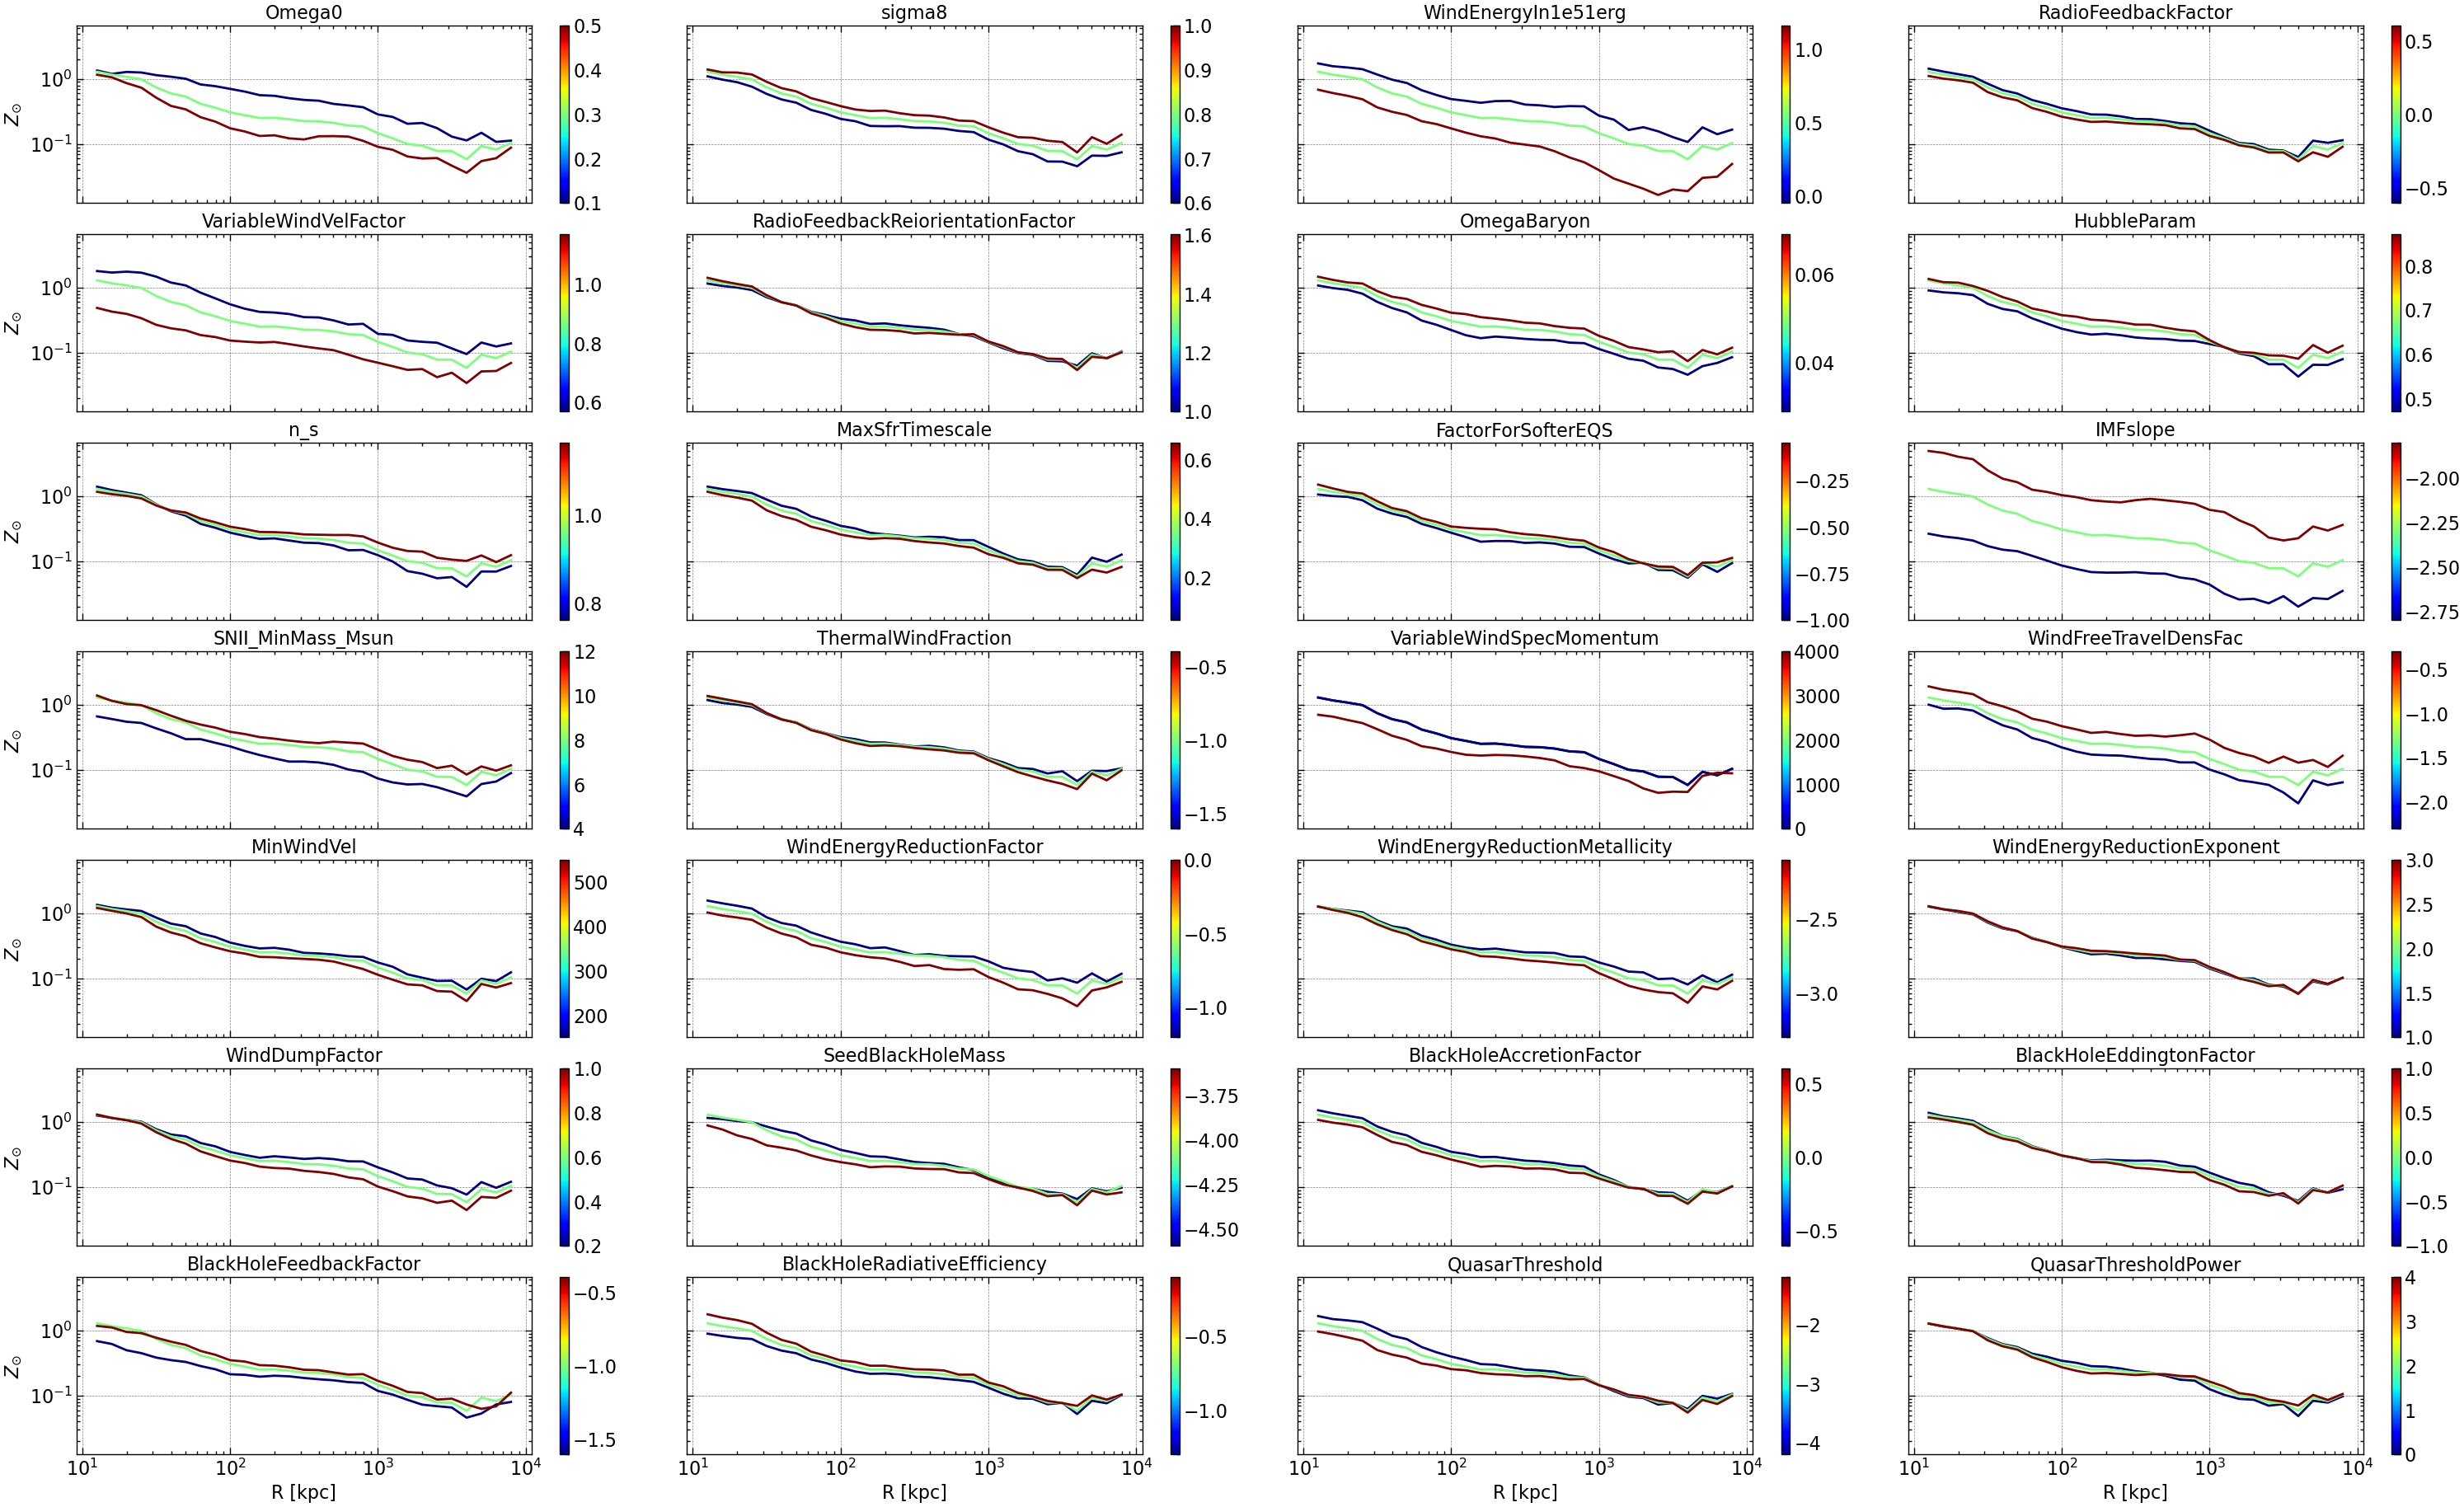

In [44]:
make_rainbow(super_dict['z']['emus'], super_dict['z']['means'], super_dict['z']['stds'])